# Nuclear Data

In this section, we will go through the salient features of the `openmc.data` package in the Python API. This package enables inspection, analysis, and conversion of nuclear data from ENDF and ACE files. Most importantly, the package provides a mean to generate HDF5 nuclear data libraries that are used by OpenMC's transport solver.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import openmc.data

## Physical Data

Some very helpful physical data is available as part of `openmc.data`: atomic masses, natural abundances, and atomic weights.

In [2]:
openmc.data.atomic_mass('Fe54')

53.939608306

In [3]:
openmc.data.NATURAL_ABUNDANCE['H2']

0.00015574

In [4]:
print(openmc.data.atomic_weight('C'))

12.011115164864455


To get the naturally occurring isotopes for a given element,

In [5]:
openmc.data.isotopes('Zr')

[('Zr90', 0.5145),
 ('Zr91', 0.1122),
 ('Zr92', 0.1715),
 ('Zr94', 0.1738),
 ('Zr96', 0.028)]

There are also some dictionaries that help converting between atomic numbers and element symbols:

In [6]:
print(openmc.data.ATOMIC_NUMBER['Br'])
print(openmc.data.ATOMIC_SYMBOL[35])

35
Br


Finally, there is a function `zam` that gives you the atomic number, mass number, and metastable state for a given nuclide name.

In [7]:
openmc.data.zam('U235')

(92, 235, 0)

The half life of an isotope can also be found. Units are in seconds

In [8]:
openmc.data.half_life('H3')

388789600.0

The `dose_coefficients` function can be used to tallying dose and is found in the `openmc.data` package:

Text(0, 0.5, 'Dose coefficient [pSv cm²]')

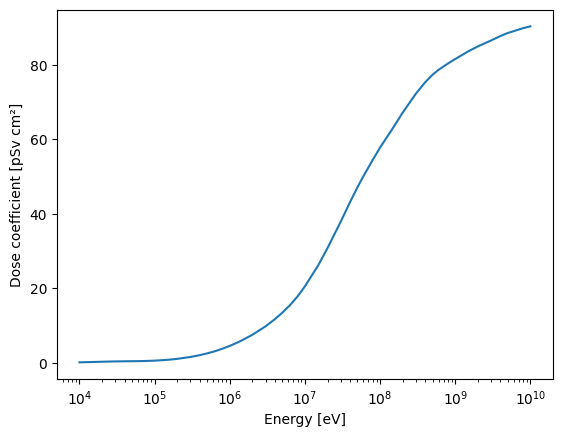

In [9]:
energy, dose_coeffs = openmc.data.dose_coefficients('photon')
plt.semilogx(energy, dose_coeffs)
plt.xlabel('Energy [eV]')
plt.ylabel('Dose coefficient [pSv cm²]')

### Decay source spectra

You can also obtain the spectrum for photons emitted from the decay of an unstable nuclide using the `decay_photon_energy` function. This function requires that a depletion chain file be specified, which is controlled through the `openmc.config` configuration variable. In this case, we'll use a chain file that is already present in the local directory

In [10]:
openmc.config['chain_file'] = 'chain_endfb71_pwr.xml'

Now we can call the `decay_photon_energy` function to get the spectrum:

In [11]:
co58_photons = openmc.data.decay_photon_energy('Co58')
co58_photons

You see that the object returned is a discrete probability distribution. We can plot this distribution through the following

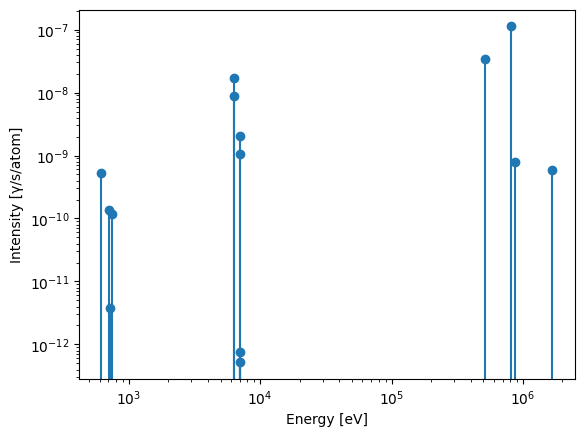

In [12]:
plt.stem(co58_photons.x, co58_photons.p)
plt.xlabel('Energy [eV]')
plt.ylabel('Intensity [γ/s/atom]')
plt.xscale('log')
plt.yscale('log')

Conveniently, the `Material` object also has a `decay_photon_energy` attribute that will combine the data for each nuclide present in the material based on the number of atoms in the material (requires that the `volume` attribute be set as well).

## The `IncidentNeutron` Class

One of the most useful class within the `openmc.data` API is `IncidentNeutron`, which stores to continuous-energy incident neutron data. This class has factory methods `from_ace`, `from_endf`, and `from_hdf5` which take a data file on disk and parse it into a hierarchy of classes in memory. To demonstrate this feature, we will start with a pregenerated HDF5 file.

In [13]:
# Load HDF5 data into object
gd157 = openmc.data.IncidentNeutron.from_hdf5('Gd157.h5')
gd157

<IncidentNeutron: Gd157>

### Cross sections

From Python, it's easy to explore (and modify) the nuclear data. Let's start off by reading the total cross section. Reactions are indexed using their "MT" number -- a unique identifier for each reaction defined by the ENDF-6 format. The MT number for the total cross section is 1.

In [14]:
total = gd157[1]
total

<Reaction: MT=1 (n,total)>

Cross sections for each reaction can be stored at multiple temperatures. To see what temperatures are available, we can look at the reaction's `xs` attribute.

In [15]:
total.xs

{'294K': <openmc.data.function.Tabulated1D at 0x15542f20bc10>}

To find the cross section at a particular energy, 1 eV for example, simply get the cross section at the appropriate temperature and then call it as a function. Note that our nuclear data uses eV as the unit of energy.

In [16]:
total.xs['294K'](1.0)

142.6474702147809

The `xs` attribute can also be called on an array of energies.

In [17]:
total.xs['294K']([1.0, 2.0, 3.0])

array([142.64747021,  38.65417611, 175.40019668])

A quick way to plot cross sections is to use the `energy` attribute of `IncidentNeutron`. This gives an array of all the energy values used in cross section interpolation for each temperature present.

In [18]:
gd157.energy

{'294K': array([1.0000e-05, 1.0325e-05, 1.0650e-05, ..., 1.9500e+07, 1.9900e+07,
        2.0000e+07])}

Text(0, 0.5, 'Cross section (b)')

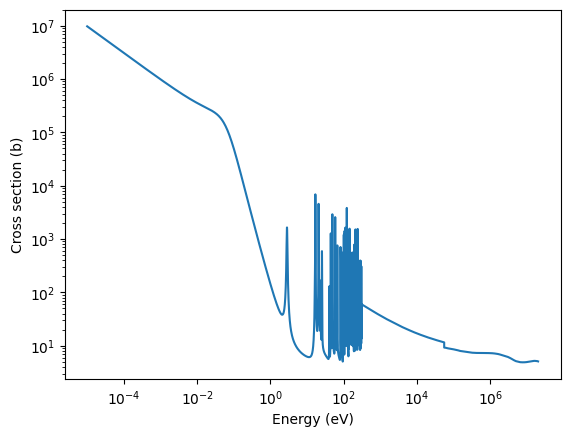

In [19]:
energies = gd157.energy['294K']
total_xs = total.xs['294K'](energies)
plt.loglog(energies, total_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')

### Reaction Data

Most of the interesting data for an `IncidentNeutron` instance is contained within the `reactions` attribute, which is a dictionary mapping MT values to `Reaction` objects.

In [20]:
list(gd157.reactions.values())[:10]

[<Reaction: MT=2 (n,elastic)>,
 <Reaction: MT=16 (n,2n)>,
 <Reaction: MT=17 (n,3n)>,
 <Reaction: MT=22 (n,na)>,
 <Reaction: MT=24 (n,2na)>,
 <Reaction: MT=28 (n,np)>,
 <Reaction: MT=41 (n,2np)>,
 <Reaction: MT=51 (n,n1)>,
 <Reaction: MT=52 (n,n2)>,
 <Reaction: MT=53 (n,n3)>]

Let's suppose we want to look more closely at the (n,2n) reaction. This reaction has an energy threshold

In [21]:
n2n = gd157[16]
print('Threshold = {} eV'.format(n2n.xs['294K'].x[0]))

Threshold = 6400881.0 eV


The (n,2n) cross section, like all basic cross sections, is represented by the `Tabulated1D` class. The energy and cross section values in the table can be directly accessed with the `x` and `y` attributes. Using the `x` and `y` has the nice benefit of automatically acounting for reaction thresholds.

In [22]:
n2n.xs

{'294K': <openmc.data.function.Tabulated1D at 0x15542ef0e080>}

(6400881.0, 20000000.0)

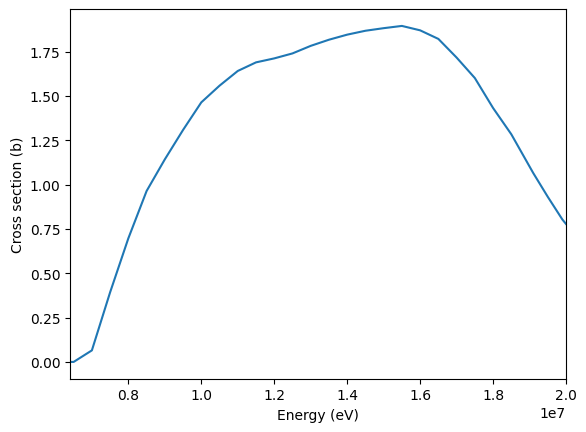

In [23]:
xs = n2n.xs['294K']
plt.plot(xs.x, xs.y)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')
plt.xlim((xs.x[0], xs.x[-1]))

To get information on the energy and angle distribution of the neutrons emitted in the reaction, we need to look at the `products` attribute.

In [24]:
n2n.products

[<Product: neutron, emission=prompt, yield=polynomial>,
 <Product: photon, emission=prompt, yield=tabulated>]

In [25]:
neutron = n2n.products[0]
neutron.distribution

We see that the neutrons emitted have a correlated angle-energy distribution. Let's look at the `energy_out` attribute to see what the outgoing energy distributions are.

In [26]:
dist = neutron.distribution[0]
dist.energy_out

Here we see we have a tabulated outgoing energy distribution for each incoming energy. Note that the same probability distribution classes that we could use to create a source definition are also used within the `openmc.data` package. Let's plot every fifth distribution to get an idea of what they look like.

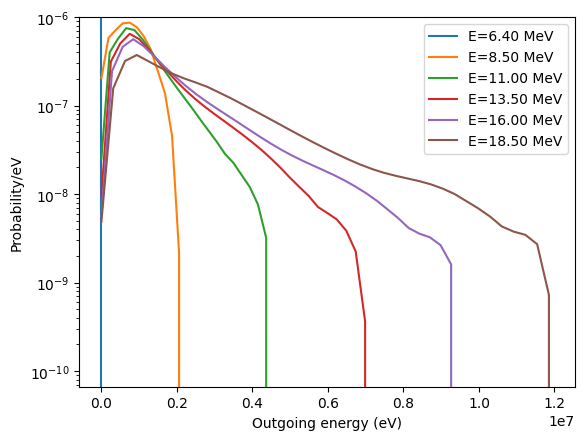

In [27]:
for e_in, e_out_dist in zip(dist.energy[::5], dist.energy_out[::5]):
    plt.semilogy(e_out_dist.x, e_out_dist.p, label='E={:.2f} MeV'.format(e_in/1e6))
plt.ylim(ymax=1e-6)
plt.legend()
plt.xlabel('Outgoing energy (eV)')
plt.ylabel('Probability/eV')
plt.show()

### Exporting HDF5 Data

If you have an instance of `IncidentNeutron` that was created from ACE or HDF5 data, you can easily write it to disk using the `export_to_hdf5()` method. This can be used to convert ACE to HDF5 or to take an existing dataset and modify cross sections.

In [28]:
gd157.export_to_hdf5('gd157_new.h5', 'w')

With few exceptions, the HDF5 file encodes the same data as what it started with:

In [29]:
gd157_new = openmc.data.IncidentNeutron.from_hdf5('gd157_new.h5')
np.all(gd157[16].xs['294K'].y == gd157_new[16].xs['294K'].y)

True

One of the best parts of using HDF5 is that it is a widely used format with lots of third-party support. You can use HDFView or a programmatic tool like `h5py` to inspect the data.

### Working with ENDF Files

The `openmc.data` package can also read ENDF files in the same way as it does for ACE and HDF5 files.

In [30]:
gd157_endf = openmc.data.IncidentNeutron.from_endf('Gd157.endf')
gd157_endf

<IncidentNeutron: Gd157>

As before, we can look at what reactions are present, their cross sections, products, angle-energy distributions, etc.

In [31]:
list(gd157_endf.reactions.values())[:10]

[<Reaction: MT=1 (n,total)>,
 <Reaction: MT=2 (n,elastic)>,
 <Reaction: MT=4 (n,level)>,
 <Reaction: MT=16 (n,2n)>,
 <Reaction: MT=17 (n,3n)>,
 <Reaction: MT=22 (n,na)>,
 <Reaction: MT=24 (n,2na)>,
 <Reaction: MT=28 (n,np)>,
 <Reaction: MT=41 (n,2np)>,
 <Reaction: MT=51 (n,n1)>]

`IncidentNeutron` objects created from ENDF files also have a special `resonances` attribute that stores resolved resonance data. This data is not present in ACE or HDF5 files.

In [32]:
rrr = gd157_endf.resonances.resolved
print(type(rrr))
rrr.parameters[:10]

<class 'openmc.data.resonance.ReichMoore'>


,energy,L,J,neutronWidth,captureWidth,fissionWidthA,fissionWidthB
0,0.0314,0,2.0,0.000474,0.1072,0.0,0.0
1,2.8250,0,2.0,0.000345,0.0970,0.0,0.0
2,16.2400,0,1.0,0.000400,0.0910,0.0,0.0
3,16.7700,0,2.0,0.012800,0.0805,0.0,0.0
4,20.5600,0,2.0,0.011360,0.0880,0.0,0.0
5,21.6500,0,2.0,0.000376,0.1140,0.0,0.0
6,23.3300,0,1.0,0.000813,0.1210,0.0,0.0
7,25.4000,0,2.0,0.001840,0.0850,0.0,0.0
8,40.1700,0,1.0,0.001307,0.1100,0.0,0.0
9,44.2200,0,2.0,0.008960,0.0960,0.0,0.0


Resolved resonance reactions (usually scattering, fission, and capture) are stored as a special `ResonancesWithBackground` object.

In [33]:
scatter = gd157_endf.reactions[2].xs['0K']
scatter

OpenMC will even let you reconstruct resonances to get a cross section at any energy.

Text(0, 0.5, 'Scatter cross section (b)')

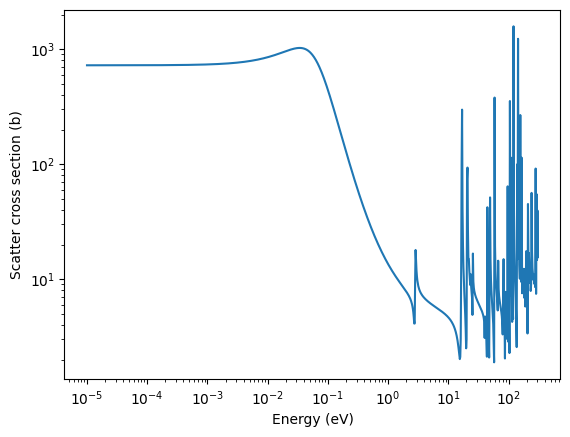

In [34]:
# Get 1000 equal-lethargy spaced energyes over the resolved resonance range
e_min = gd157_endf.resonances.resolved.energy_min
e_max = gd157_endf.resonances.resolved.energy_max
energies = np.logspace(np.log10(e_min), np.log10(e_max), 1000)

# Calculate the scattering cross section
scatter_xs = scatter(energies)

# and plot it
plt.loglog(energies, scatter_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Scatter cross section (b)')

### Generating data from NJOY

To run OpenMC in continuous-energy mode, you generally need to have ACE files already available that can be converted to OpenMC's native HDF5 format. If you don't already have suitable ACE files or need to generate new data, both the `IncidentNeutron` and `ThermalScattering` classes include `from_njoy()` methods that will run NJOY to generate ACE files and then read those files to create OpenMC class instances. The `from_njoy()` methods take as input the name of an ENDF file on disk. By default, it is assumed that you have an executable named `njoy` available on your path. This can be configured with the optional `njoy_exec` argument. Additionally, if you want to show the progress of NJOY as it is running, you can pass `stdout=True`.

Let's use `IncidentNeutron.from_njoy()` to run NJOY to create data for <sup>2</sup>H using an ENDF file. We'll specify that we want data specifically at 300, 400, and 500 K.

In [35]:
h2 = openmc.data.IncidentNeutron.from_njoy('H2.endf', temperatures=[300., 400., 500.], stdout=True)


 njoy 2016.68  30Sep22                                       10/18/22 06:25:41
 *****************************************************************************

 reconr...                                                                0.0s

 broadr...                                                                0.0s
      300.0 deg                                                           0.0s
      400.0 deg                                                           0.1s
      500.0 deg                                                           0.2s

 heatr...                                                                 0.2s

 heatr...                                                                 0.3s

 gaspr...                                                                 0.5s

 purr...                                                                  0.5s

 mat =  128                                                               0.5s

 ---message from purr---mat  128 has no res

In [36]:
ngamma = h2[102]
ngamma.xs

{'300K': <openmc.data.function.Tabulated1D at 0x15542d6f2e90>,
 '400K': <openmc.data.function.Tabulated1D at 0x15542d7445e0>,
 '500K': <openmc.data.function.Tabulated1D at 0x15542d744070>}

## Building a `cross_sections.xml` file

The `DataLibrary` class enables you to easily build your own custom cross_sections.xml files (analog to MCNP's xsdir and Serpent's xsdata files).

In [37]:
lib = openmc.data.DataLibrary()

Once we have a data library, all we need to do is register the file names that we want to be part of it,

In [38]:
lib.register_file('Gd157.h5')
...

and the export it using the `export_to_xml()` method:

In [39]:
lib.export_to_xml('cross_sections.xml')

Let's confirm this actually created the file:

In [40]:
!cat cross_sections.xml

<?xml version='1.0' encoding='utf-8'?>
<cross_sections>
  <library materials="Gd157" path="Gd157.h5" type="neutron" />
</cross_sections>


## `Decay` and `FissionProductYields`

You can also find classes for reading decay and fission product yield data stored in ENDF files. Unlike the `IncidentNeutron` class, there are no factory `from_*` methods because these data only come from a single source: ENDF files. Thus, we instantiate them directly with the filename:

In [41]:
ga70 = openmc.data.Decay('dec-031_Ga_070.endf')

Now we can look at the basic data such as the half-life, decay modes, average energies, etc.

In [42]:
ga70.half_life

1268.4+/-1.8

In [43]:
ga70.modes

[<DecayMode: (beta-), Ga70 -> Ge70, 0.9959+/-0.0006>,
 <DecayMode: (ec/beta+), Ga70 -> Zn70, 0.0041+/-0.0006>]

In [44]:
ga70.average_energies

{'light': 644048.3+/-1490.423,
 'electromagnetic': 7288.224+/-519.8623,
 'heavy': 0.0+/-0}

For the more adventurous, you can even look at the decay particle spectra:

In [45]:
ga70.spectra['gamma']

{'type': 'gamma',
 'continuous_flag': 'discrete',
 'discrete_normalization': 1.0+/-0,
 'energy_average': 7272.281+/-519.8595,
 'continuous_normalization': 0.0+/-0,
 'discrete': [{'energy': 176170.0+/-20.0,
   'from_mode': ['beta-'],
   'type': None,
   'intensity': 0.002938043+/-9.187973e-05,
   'internal_pair': 0.0+/-0,
   'total_internal_conversion': 0.08914211+/-0.001110331,
   'k_shell_conversion': 0.07874+/-0.001103,
   'l_shell_conversion': 0.008992+/-0.000126},
  {'energy': 1039200.0+/-80.0,
   'from_mode': ['beta-'],
   'type': None,
   'intensity': 0.006499891+/-0.0005000069,
   'internal_pair': 0.0+/-0,
   'total_internal_conversion': 0.0003231935+/-4.066633e-06,
   'k_shell_conversion': 0.0002889+/-4.045e-06,
   'l_shell_conversion': 2.959e-05+/-4.143e-07}]}

A more convenient form of this data can be found in the `sources` attribute:

In [46]:
ga70.sources

{'photon': <openmc.stats.univariate.Discrete at 0x15542d7467d0>,
 'electron': <openmc.stats.univariate.Discrete at 0x15542d7469e0>,
 'positron': <openmc.stats.univariate.Discrete at 0x15542d746980>}

Let's look at fission product yields for <sup>235</sup>U:

In [47]:
u235 = openmc.data.FissionProductYields('nfy-092_U_235.endf')

First, we can see what incident neutron energies we have FPY available for:

In [48]:
u235.energies

array([2.53e-02, 5.00e+05, 1.40e+07])

Now we can get the independent or cumulative yields for a given energy:

In [49]:
u235.independent[0]['I135']  # yields for 0.0253 eV

0.0292737+/-0.000819663

With a little bit of Python, we can answer questions such as: which fission product from U235 has the highest yield?

In [50]:
max(u235.independent[0].items(), key=lambda x: x[1])

('Te134', 0.062155+/-0.0024862)